In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
import lightkurve
from astropy import units
from astropy.io import fits
# import exoplanet as xo

In [49]:
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)
ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])
names = np.array(m_dwarf_sample[m_dwarf_sample.columns[2]])
masses = np.array(m_dwarf_sample[["Mass"]])
comps = [i[0].strip() for i in np.array(m_dwarf_sample[["Comp"]])]

ras = [i.replace(' ',':') for i in ra]
decs = [i.replace(' ',':') for i in dec]

coords = []
for i in range(len(decs)):
    coords.append(ras[i]+" "+decs[i])

In [75]:
all_star_sample = pd.read_csv('/Users/caleb/research/Astro_98/all_stars_mags_mass.csv',delimiter=',',index_col=0)
gjs = np.array(all_star_sample['GJ'])
comps = np.array(all_star_sample['Comp'])

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/heavy_names.pkl','rb') as f:
    names = pickle.load(f)


In [3]:
# download data

def download_data():

    lc_datas = []
    for i in tqdm(range(len(coords))):
        try:
            search_result = lightkurve.search_lightcurve(coords[i],exptime='fast',mission='TESS')
            # search_result.table["dataURL"] = search_result.table["dataURI"]  # workaround MAST issue
            data = search_result.download_all()
            lc_datas.append(data)
        except:
            search_result = lightkurve.search_lightcurve(coords[i],exptime='fast',mission='TESS')
            search_result.table["dataURL"] = search_result.table["dataURI"]  # workaround MAST issue
            data = search_result.download_all()
            lc_datas.append(data)


In [65]:
with open(f'/Users/caleb/research/Astro_98/lightkurve_data/perio_data/stars_analyzed.pkl','rb') as f:
    pw = pickle.load(f)

In [69]:
lightkurve.search_lightcurve(' * ups And B',mission='TESS')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 17,2019,SPOC,120,189576919,0.0
1,TESS Sector 58,2022,SPOC,20,189576919,0.0
2,TESS Sector 58,2022,SPOC,120,189576919,0.0
3,TESS Sector 17,2019,TESS-SPOC,1800,189576919,0.0
4,TESS Sector 58,2022,TESS-SPOC,200,189576919,0.0
5,TESS Sector 17,2019,QLP,1800,189576919,0.0
6,TESS Sector 58,2022,QLP,200,189576919,0.0


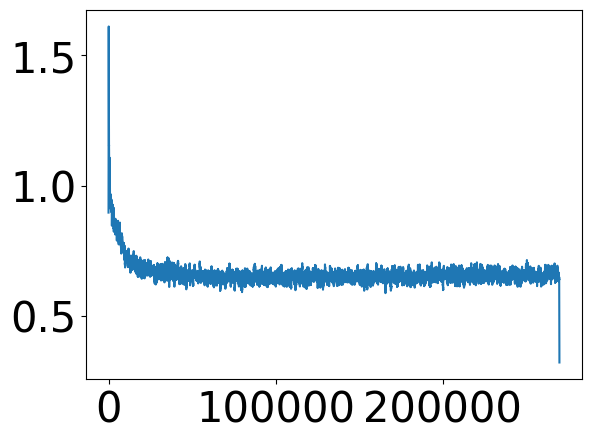

In [41]:
plt.plot(pw)
# plt.xscale('log')
# plt.yscale('log')

In [49]:
freq = np.arange(2, 2160,0.008)

In [11]:
def split_obs(lcs):
    result = []
    current_subarray = [lcs[0]]

    for i in range(1, len(lcs)):
        if abs(lcs.sector[i]-lcs.sector[i - 1]) < 3:
            current_subarray.append(lcs[i])
        else:
            result.append(current_subarray)
            current_subarray = [lcs[i]]

    result.append(current_subarray)
    result = [lightkurve.LightCurveCollection(i) for i in result]
    return result

In [70]:
def get_paths(target):
    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)
    all_paths = []

    if target == '':
        for num in range(1000):
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/{num}_*_lc.fits"))]
            all_paths.append(file_paths)

    else:
        file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/{target}_*_lc.fits"))]
        all_paths.append(file_paths)

    return all_paths


In [85]:
def process(lc,smooth_size): 
    # flatten and remove flares
    clean_lc = lc.remove_nans().remove_outliers(3)
    clean_lc.plot()
    ppm_unit = clean_lc.flux[0].unit
    flat_lc, trend_lc = clean_lc.flatten(window_length=smooth_size, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)
    flat_lc = flat_lc.remove_outliers(3)
    # residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
    # flat_lc['flux'] = residuals
    flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6
    # flat_lc = flat_lc.remove_outliers(3)
    # get perio
    # frequency = np.arange(1, 4000,0.008)
    flat_lc.plot()

    perio = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
    threshold =  4*np.mean(np.array(perio.power))
    threshold_freq = [(i*10**6)/(24*60*60) for i in np.array(perio.smooth(filter_width=20).frequency)]
    # perio = perio.smooth(filter_width=2)
    perio_psd = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,.1),normalization='psd').smooth(filter_width=2)

    # get thresholds

    # flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).plot()
    # plt.axhline(y=threshold,color='red')
    # plt.show()
    perio_psd.plot(scale='log')
    plt.show()
    
    frequency_hz = [(i*10**6)/(24*60*60) for i in np.arange(2, 2160,0.008)]
    # indices
    plt.figure(figsize=(10,5))
    plt.plot(frequency_hz,np.array(flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).power),color='black',alpha=.8)
    plt.xlabel("Frequency [uHz]",fontsize=15)
    plt.ylabel("Amp. [ppm]",fontsize=15)
    plt.axhline(y=threshold,color='red')
    plt.tick_params(labelsize=10)
    # plt.xscale('log')
    plt.show()
    print('max',frequency_hz[np.argmax(np.array(perio.power))])
    return perio, perio_psd, threshold

In [24]:
def get_perio(lc_data,smooth_size):
    consecutive_lcs = split_obs(lc_data)

    perios = []
    perio_psds = []
    flats = []


    thresholds = []


    for lcs in consecutive_lcs:
        if len(lcs) > 1:
            lc = lcs.stitch().normalize(unit='ppm')
            perio, perio_psd,threshold = process(lc,smooth_size)
            ppm_unit = perio.power[0].unit
            psd_unit = perio_psd.power[0].unit
            perios.append(np.array(perio.power))
            perio_psds.append(np.array(perio_psd.power))
            thresholds.append(threshold)
        else:
            for lc in lcs:
                lc = lc.normalize(unit='ppm')
                perio, perio_psd,threshold = process(lc,smooth_size)
                ppm_unit = perio.power[0].unit
                psd_unit = perio_psd.power[0].unit
                thresholds.append(threshold)
                perios.append(np.array(perio.power))
                perio_psds.append(np.array(perio_psd.power))

    
    summed_perio = sum(perios)
    summed_perio_psd = sum(perio_psds)

    perio.power = np.array(summed_perio)*ppm_unit
    perio_psd.power = np.array(summed_perio_psd)*psd_unit
    return perio, perio_psd, np.min(thresholds)

In [25]:
def get_fake_lc(lc):
    rand = np.random.default_rng(42)
    lc = lc.remove_nans()
    t = lc.time.value
    clean_lc = lc.remove_outliers(4)


    noise = np.std((clean_lc['flux'])) * np.random.normal(size=len(t))
    baseline = np.mean((clean_lc['flux']))


    lc['flux'] = (noise+baseline)
    print(lc['flux'])

    return lc

In [64]:
def analyze_star(star_num,fake,smooth_size):

    all_paths = get_paths('')
    print(all_paths)
    powers = []
    power_psds = []
    flats = []
    thresholds = []
    dilutions = []
    stars_analyzed = []

    stars = [star_num]

    for num in stars:
        # try:
            if len(all_paths[num]) != 0:
                if len(all_paths[num]) > 0:
                    print(all_paths[num])
                    lcs_list = []

                    # if exp_time != 'fast': 
                    #     search_result = lk.search_lightcurve('GJ 1243',mission='TESS',exptime=exp_time)
                    #     lc = search_result[1].download()
                    #     lcs_list.append(lc)

                    for i in all_paths[num]:
                        lc = lightkurve.io.read(f'{i}')
                        if fake == True:
                            lc = get_fake_lc(lc)
                        # lc.plot()
                        lcs_list.append(lc)
                lcs = lightkurve.LightCurveCollection(lcs_list)
                # else:
                #     lc = lightkurve.io.read(f'{all_paths[num][0]}')

                #     # make fake data
                #     if fake == True:
                #         lc = get_fake_lc(lc)
                #     lcs = lightkurve.LightCurveCollection(lc)

                print(lcs)
                # get contamination
                dilution = lc.meta["CROWDSAP"]

                # sort lightkurves by sector
                sorted_indexes = sorted(range(len(lcs.sector)), key=lambda x: lcs.sector[x])
                lcs = lcs[sorted_indexes]
                perio, perio_psd,threshold = get_perio(lcs,smooth_size)

                # perio.plot(scale='log')
                # perio_psd.plot(scale='log')

                fig, axs = plt.subplots(2,1,figsize=(10,10))
                lc.remove_outliers().scatter(ax=axs[0],color='black',alpha=.9)

                flat = perio_psd.flatten()
                flat.plot(ax=axs[1],title=f'Star {num} -- {names[num]} {comps[num]}',color='black',alpha=.9)
                axs[0].tick_params(labelsize=20)
                axs[1].tick_params(labelsize=20)
                plt.rcParams.update({'font.size': 30})
                plt.tight_layout()
                axs[0].set_xlabel("Time [d]",fontsize=25)
                axs[0].set_ylabel("Flux [e/s]",fontsize=25)
                axs[1].set_xlabel("Frequency [uHz]",fontsize=25)
                axs[1].set_ylabel("SNR",fontsize=25)

                plt.savefig(f'lightkurve_data/power_plots/{num}_flat_power.png')
                plt.show()
                plt.close()

                # get maximum value and zoom in on it
                # print(flat)
                # print(np.argmax(np.array(flat.power)))
                # freq_index_mas = flat.frequency.

                fig, axs = plt.subplots(1,2,figsize=(20,10))
                max_index = list(flat.frequency).index(flat.frequency[np.argmax(flat.power)])
                perio_psd[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=axs[0],color='black',alpha=.85)
                flat[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=axs[1],color='black',alpha=.85)

                # flat_perio = perio.smooth(filter_width=2)
                # flat_perio.plot(color='red')
                powers.append(perio.power)
                power_psds.append(perio_psd.power)
                thresholds.append(threshold)
                flats.append(np.array(flat.power))
                dilutions.append(dilution)
                stars_analyzed.append(num)

            else:
                powers.append(np.array([]))
                power_psds.append(np.array([]))
                thresholds.append(-1)
                flats.append(np.array([]))
                dilutions.append(-1)
                stars_analyzed.append(num)
        # except:
        #     print("error on star: ",num)



    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/thresholds.pkl','wb') as f:
        pickle.dump(thresholds,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/power_psds.pkl','wb') as f:
        pickle.dump(power_psds,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/flats.pkl','wb') as f:
        pickle.dump(flats,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/powers.pkl','wb') as f:
        pickle.dump(powers,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/dilutions.pkl','wb') as f:
        pickle.dump(dilutions,f)

    with open(f'/Users/caleb/research/Astro_98/lightkurve_data/stars_analyzed.pkl','wb') as f:
        pickle.dump(stars_analyzed,f)



In [82]:
all_star_sample[878:882]

,GJ,Comp,NComp,P?,GJp,GaiaDR3,HIP,RAJ2000,DEJ2000,Epoch,...,Jmag,Hmag,Ksmag,W1mag,W2mag,W3mag,W4mag,SimbadName,Mass,distance
CNS5,,,,,,,,,,,,,,,,,,,,,
3633,3863.0,,,0,,5793182631952977920,71855,220.470678,-75.139566,2016.0,...,5.525,5.214,5.072,5.096,4.942,5.098,5.049,HIP 71855,0.629571,20.251114
3262,11909.0,,,0,,5765846127180770432,64690,198.836956,-87.561378,2016.0,...,5.882,5.572,5.443,5.503,5.378,5.507,5.466,HIP 64690,0.588091,24.703557
2869,438.0,,,0,,5369480397355535872,,175.837290,-51.842934,2016.0,...,7.144,6.580,6.320,6.199,5.992,6.030,5.913,Gaia DR3 5369480397355535872,0.433884,11.018070
2451,375.0,,,0,,5408648849826522112,48904,149.646107,-46.427246,2016.0,...,7.127,6.519,6.257,6.173,5.894,5.908,5.783,HIP 48904,0.446019,15.444015


In [81]:
gjs[880]

438.0

In [97]:
names[44]

'Gaia DR3  240259375324767744'

In [98]:
lk.search_lightcurve('Gaia DR3  240259375324767744', mission='TESS',exptime=20)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 58,2022,SPOC,20,192468220,0.0


[['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/0_0_lc.fits'], [], [], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/4_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/5_0_lc.fits'], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/7_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/7_1_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/8_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/9_0_lc.fits'], [], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/12_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/13_1_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/13_0_lc.fits'], [], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_3_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_2_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_0_lc.fi

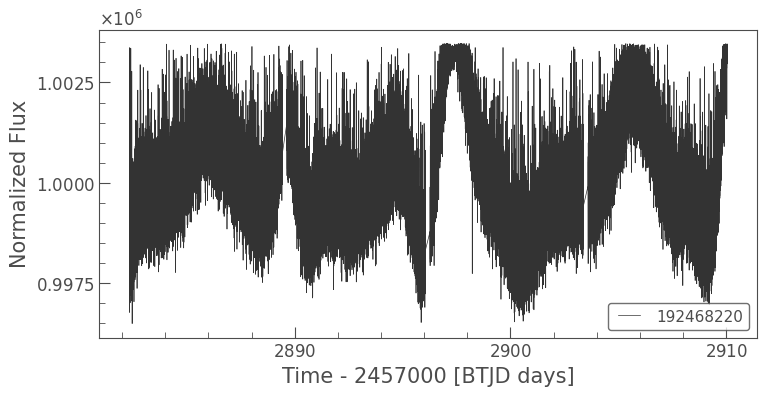

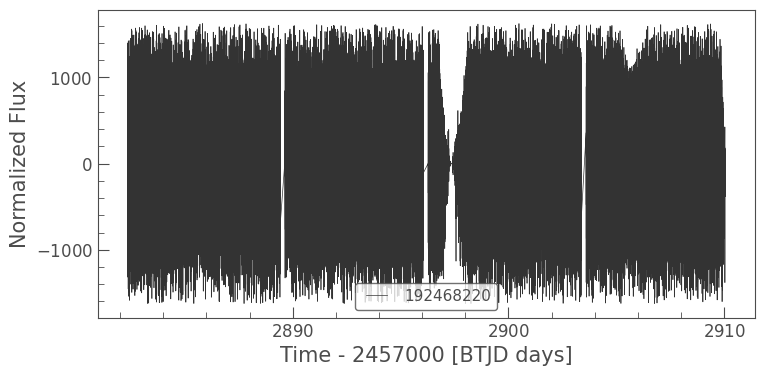

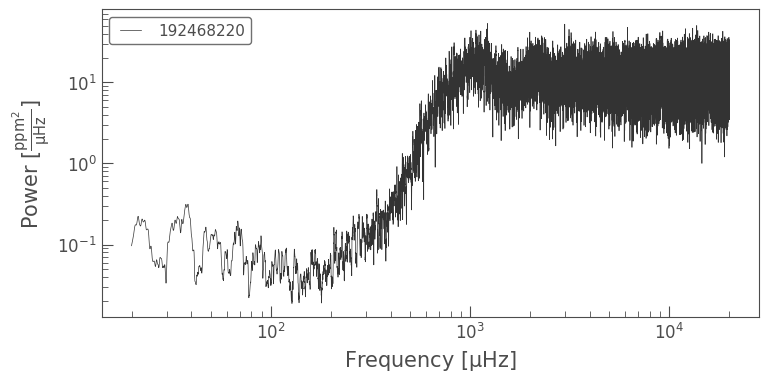

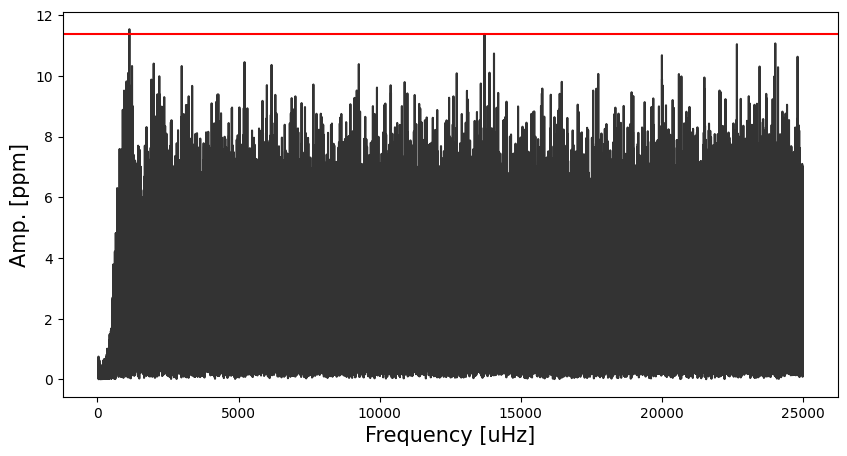

max 1079.1666666666674


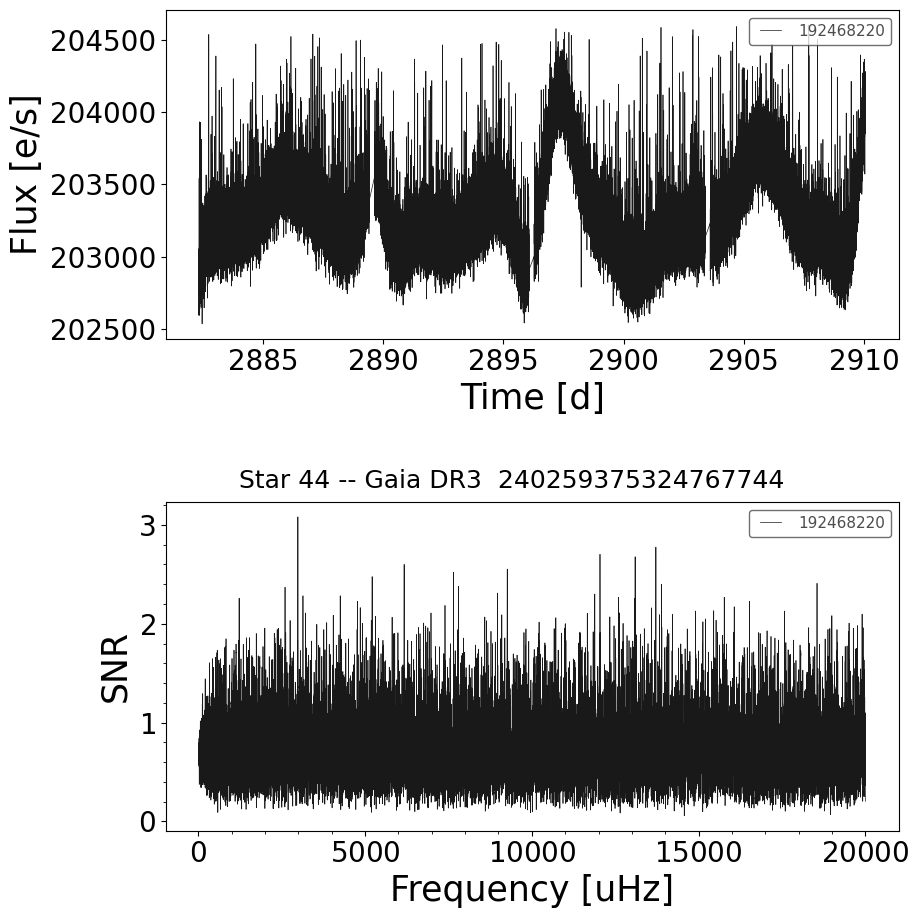

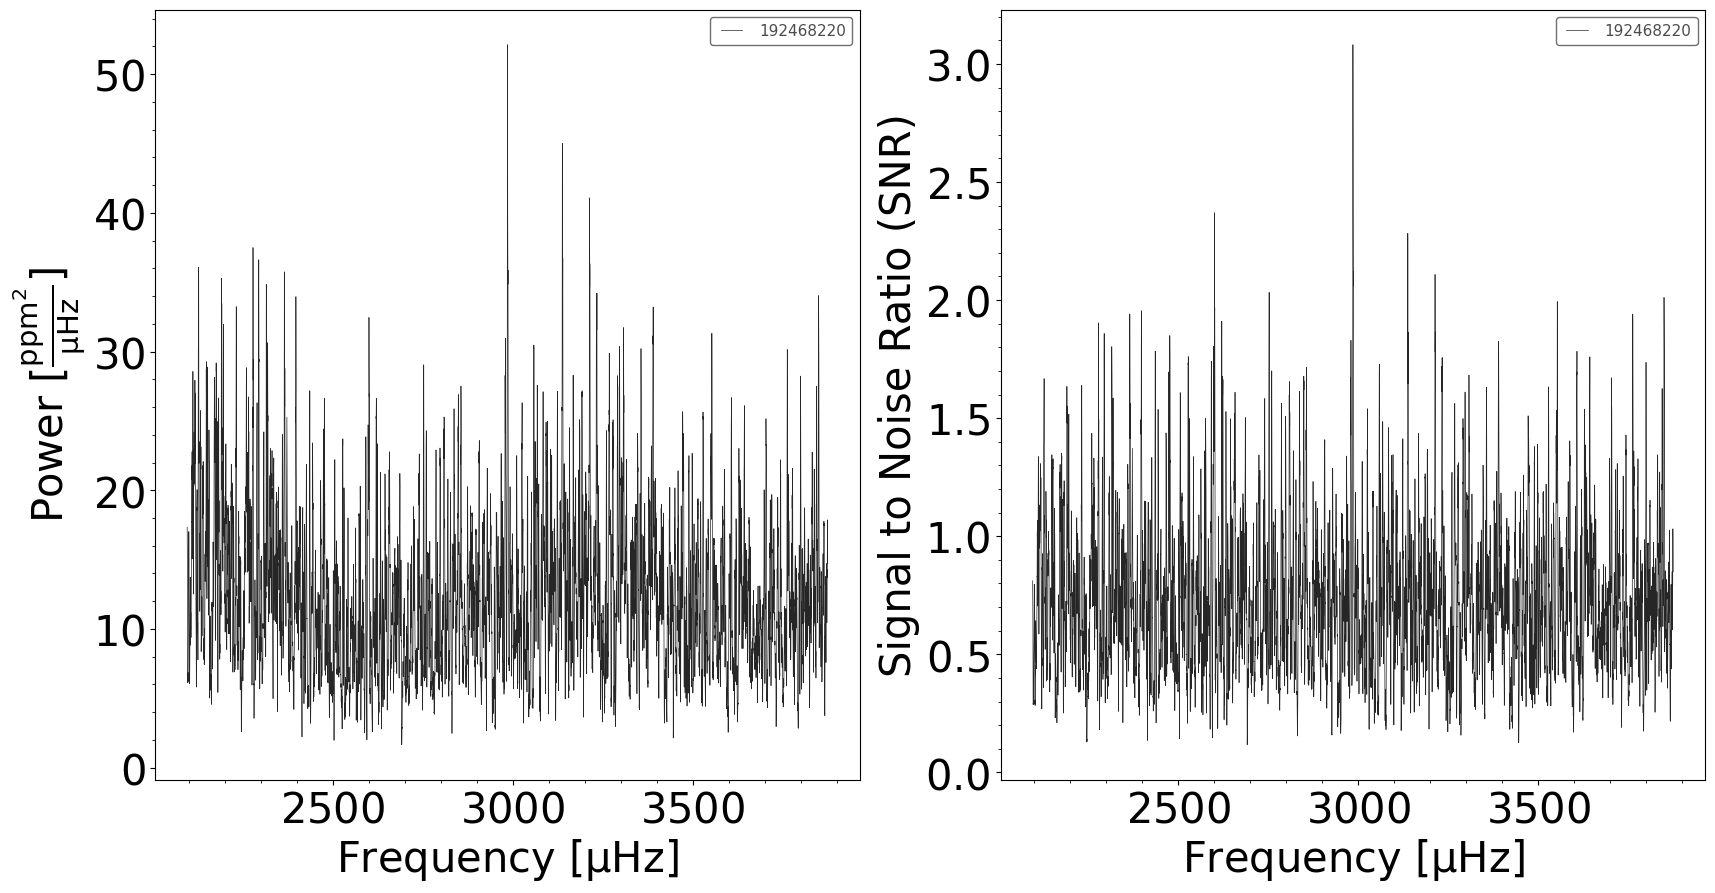

In [91]:
analyze_star(44,False,101)

[['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/0_0_lc.fits'], [], [], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/4_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/5_0_lc.fits'], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/7_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/7_1_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/8_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/9_0_lc.fits'], [], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/12_0_lc.fits'], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/13_1_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/13_0_lc.fits'], [], [], ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_3_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_2_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_0_lc.fi

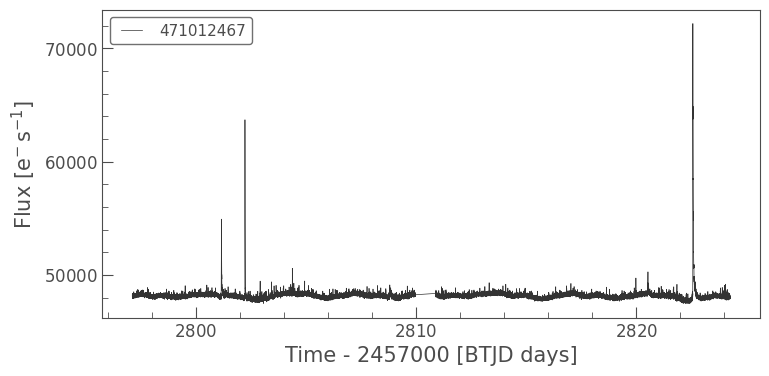

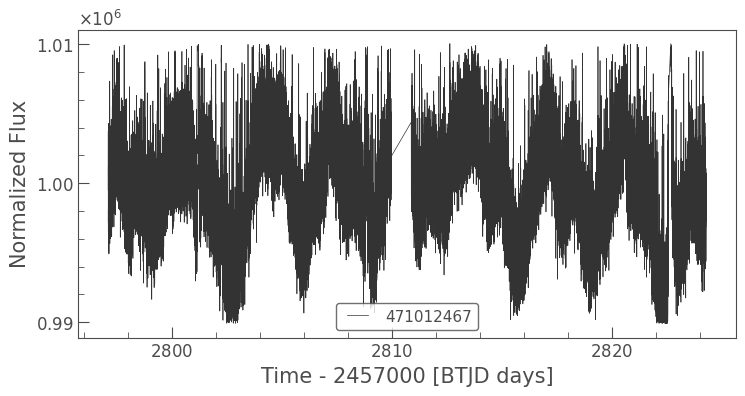

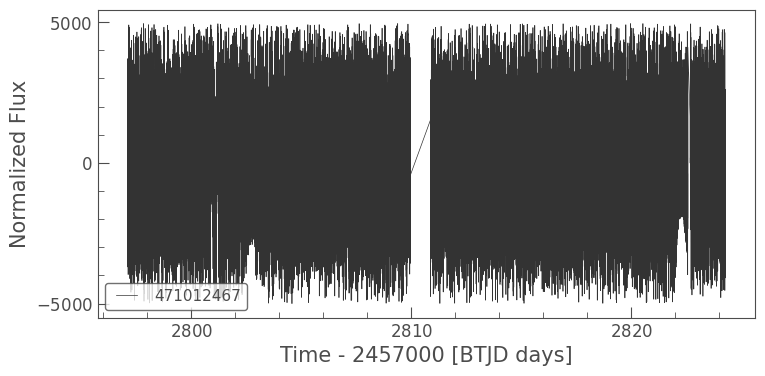

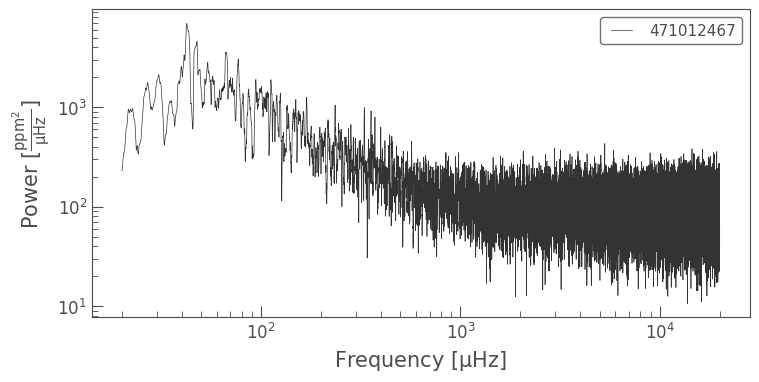

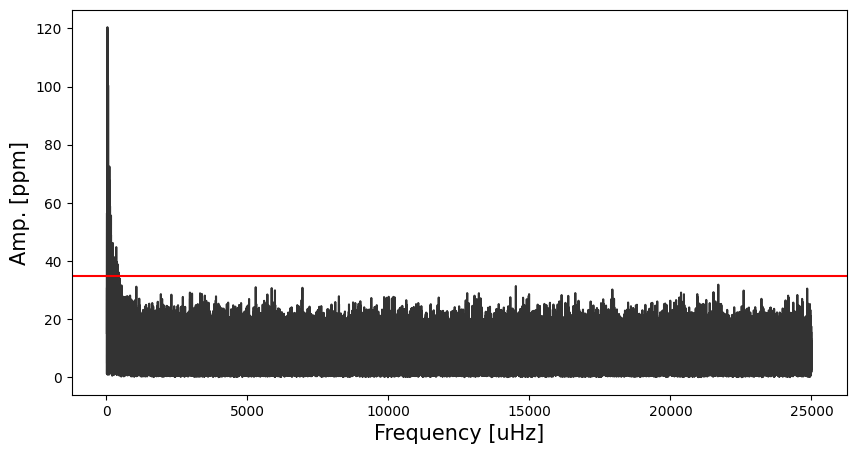

max 48.611111111111136


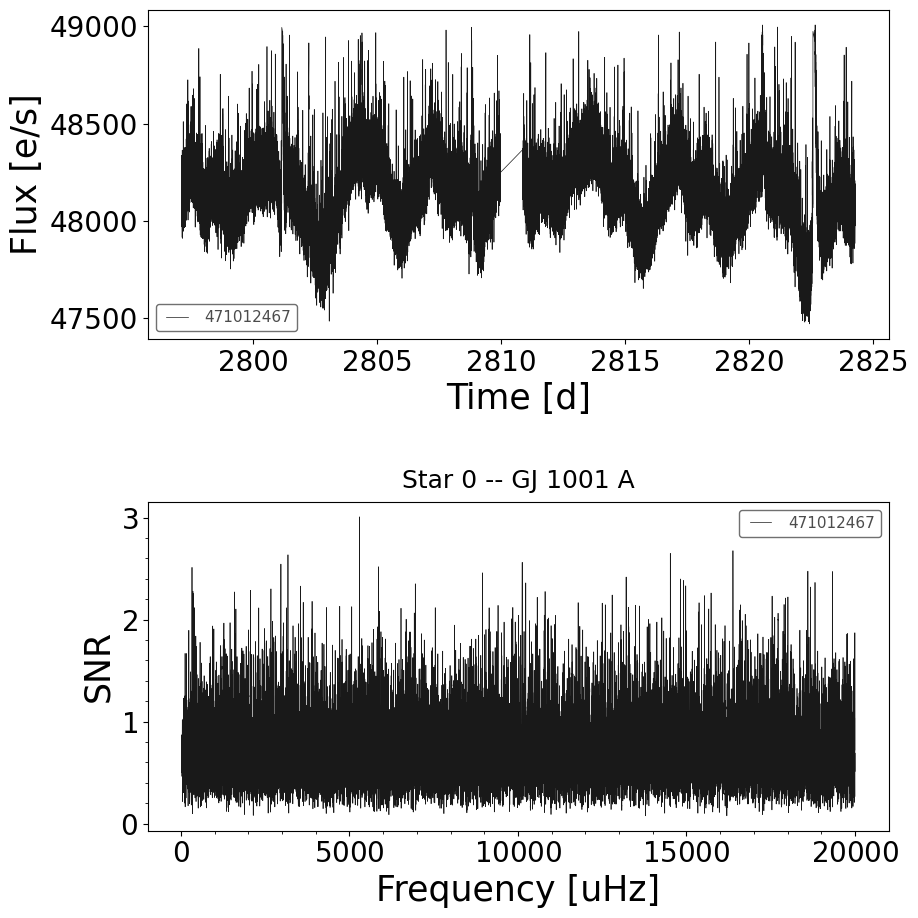

In [46]:
analyze_star(0,False,2001)

[['/Users/caleb/research/Astro_98/lightkurve_data/testGJ143_1_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/testGJ143_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/testGJ143_2_lc.fits']]
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 273589987" SECTOR=15 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


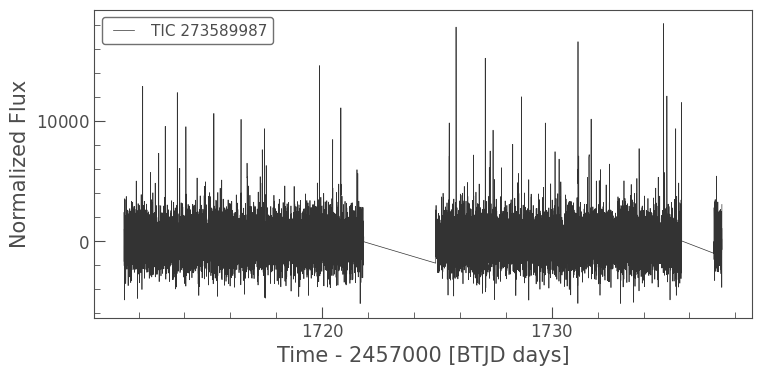

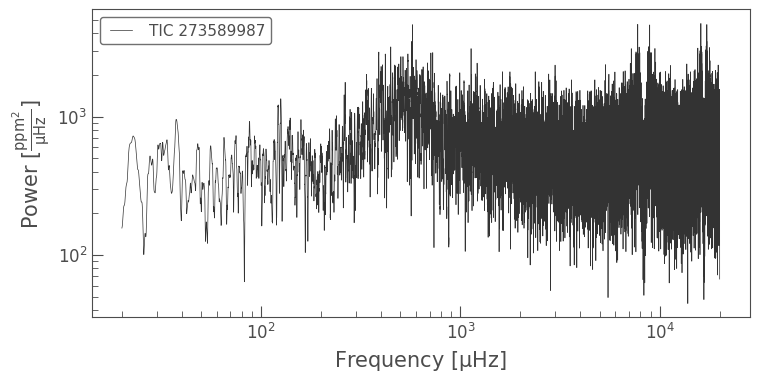

/Users/caleb/opt/anaconda3/envs/astron/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


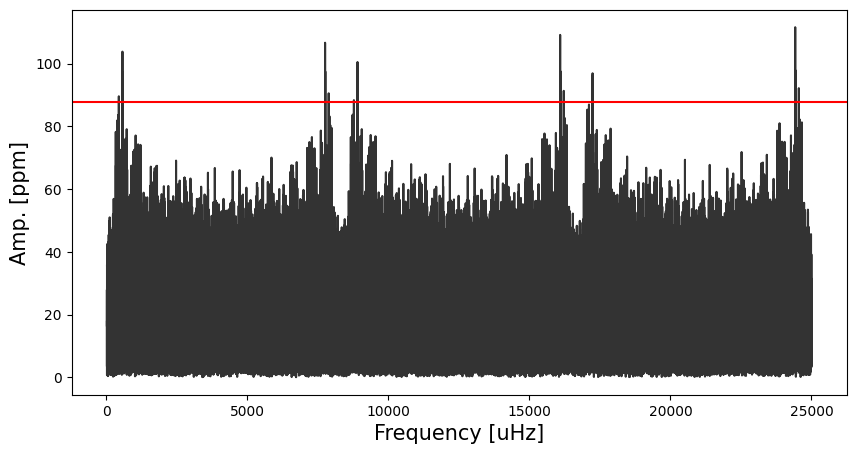

max 24503.88888888891


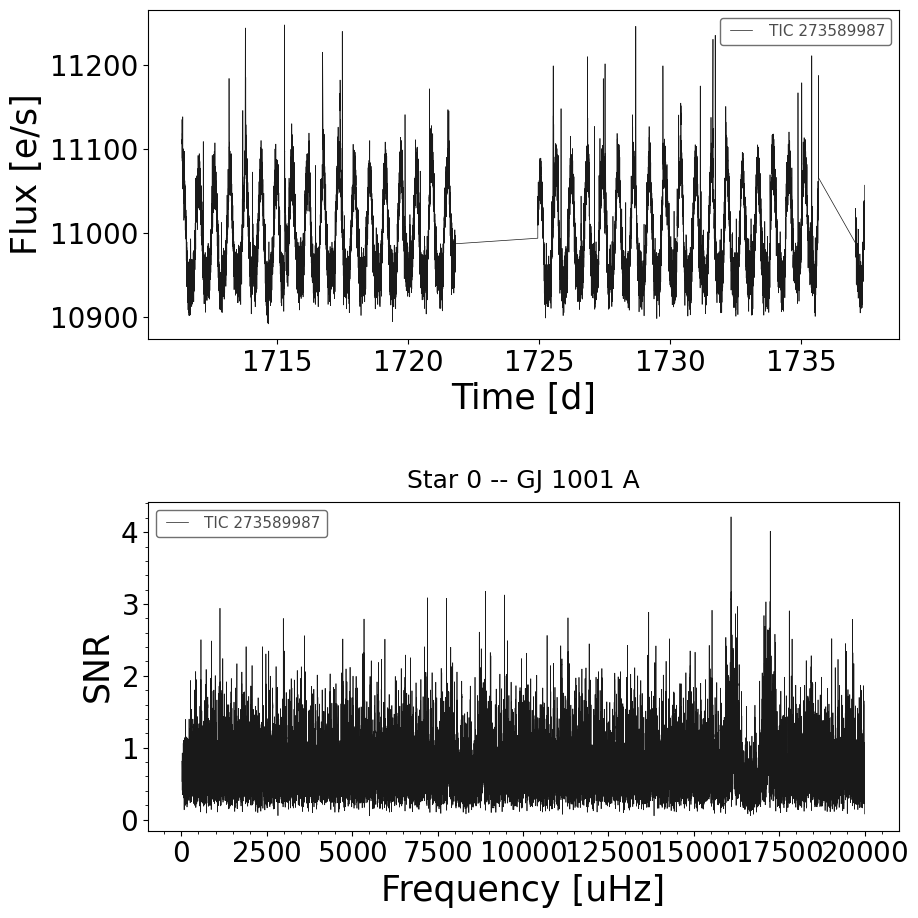

In [293]:
analyze_star(134,False,smooth_size = 31,exp_time='short')

[['/Users/caleb/research/Astro_98/lightkurve_data/testGJ143_1_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/testGJ143_0_lc.fits', '/Users/caleb/research/Astro_98/lightkurve_data/testGJ143_2_lc.fits']]
LightCurveCollection of 3 objects:
    0: <TessLightCurve LABEL="273589987" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="273589987" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="273589987" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


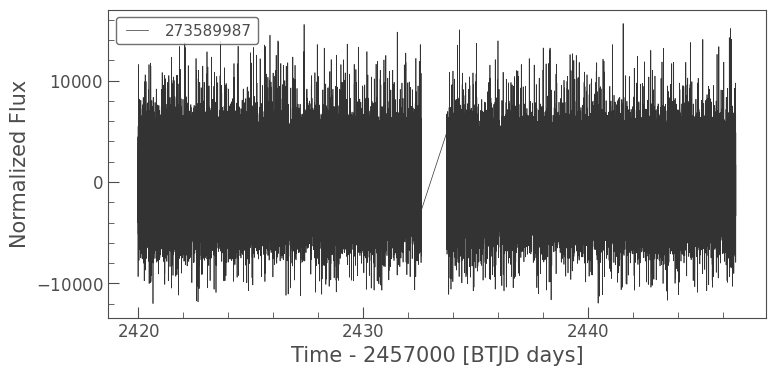

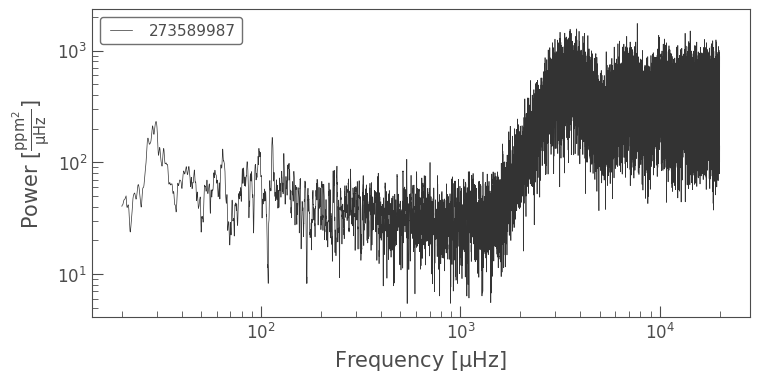

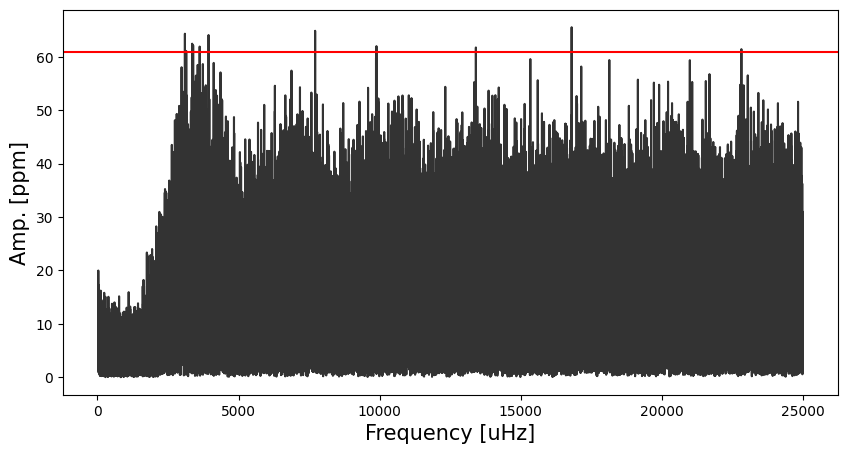

max 3547.962962962966


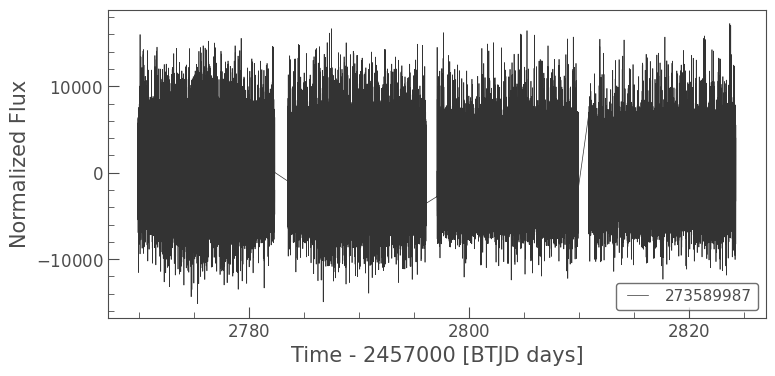

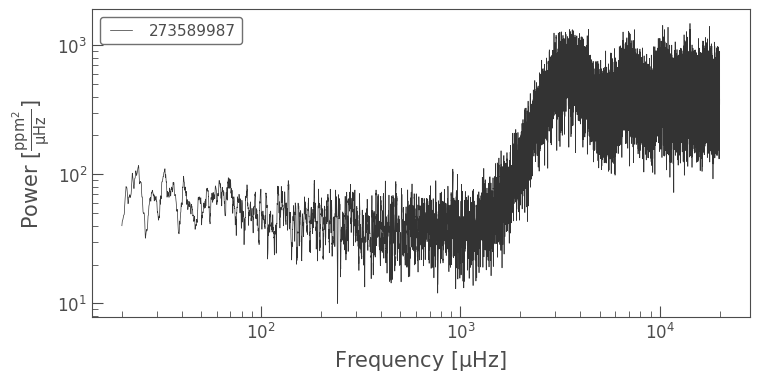

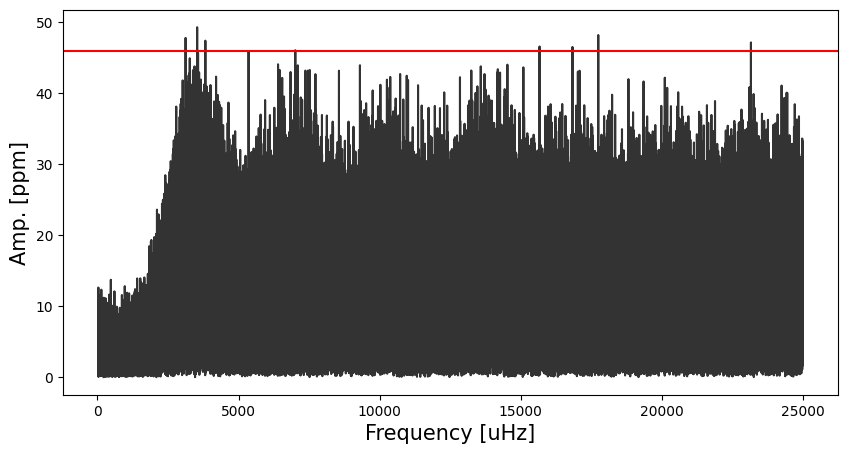

max 3647.8703703703736


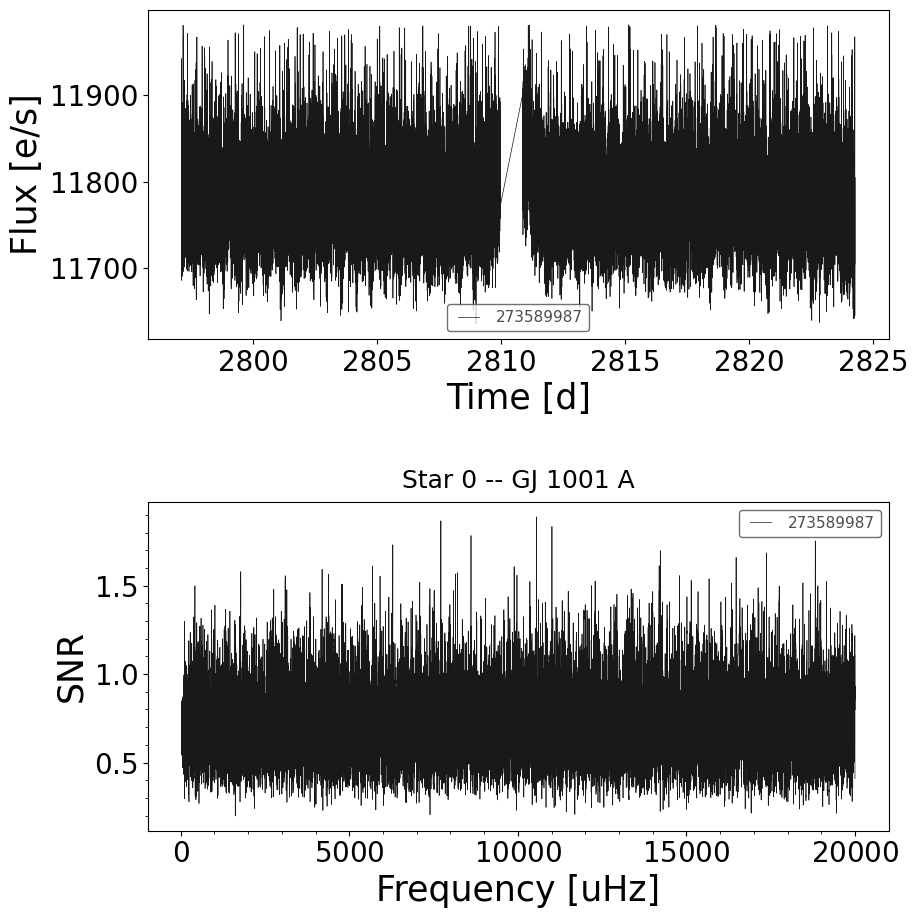

In [292]:
analyze_star(134,False,smooth_size = 31,exp_time='fast')

LightCurveCollection of 20 objects:
    0: <TessLightCurve LABEL="141810080" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="141810080" SECTOR=66 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="141810080" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="141810080" SECTOR=67 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="141810080" SECTOR=30 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="141810080" SECTOR=65 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="141810080" SECTOR=37 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="141810080" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="141810080" SECTOR=29 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="141810080" SECTOR=64 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="141810080" SECTOR=61 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_f

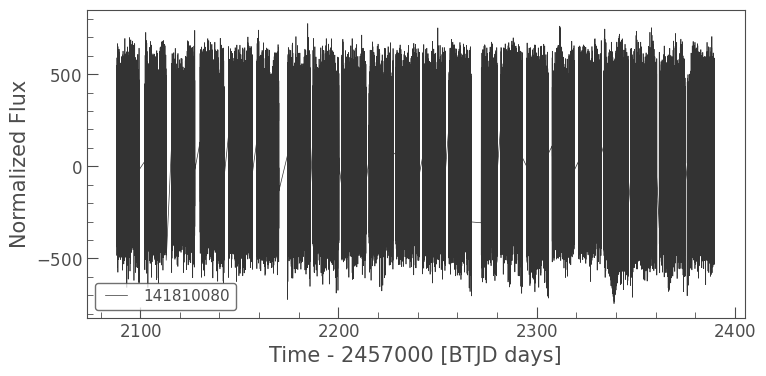

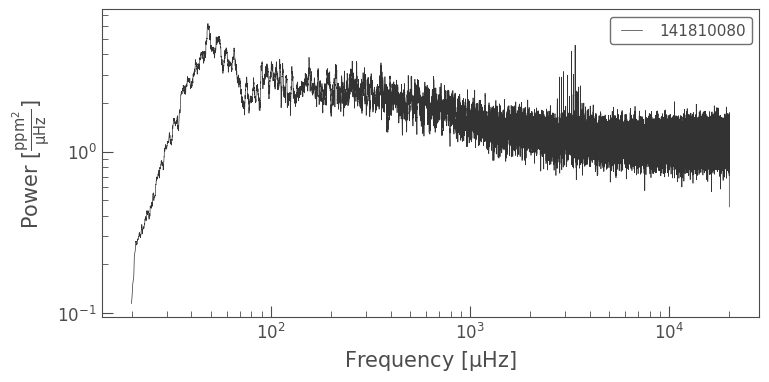

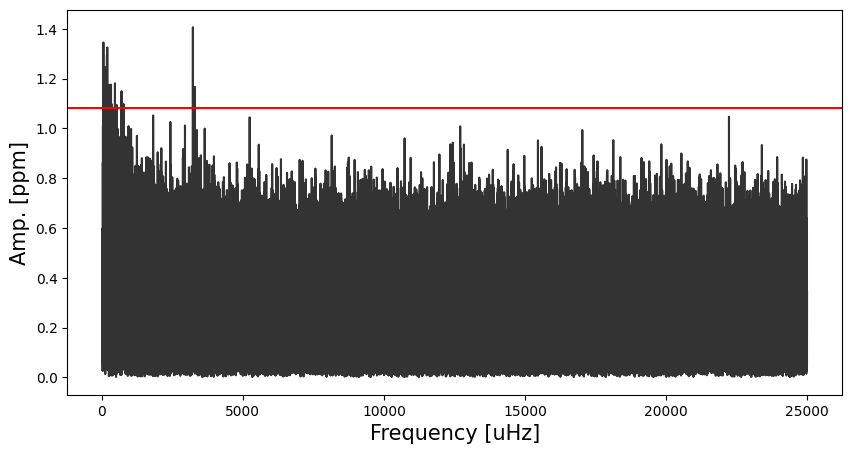

max 53.98148148148152


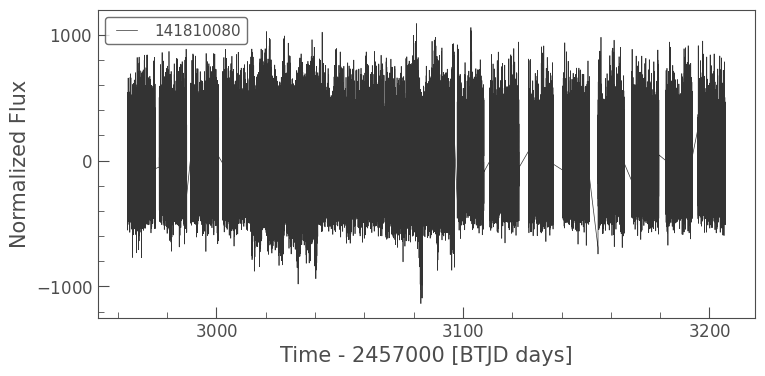

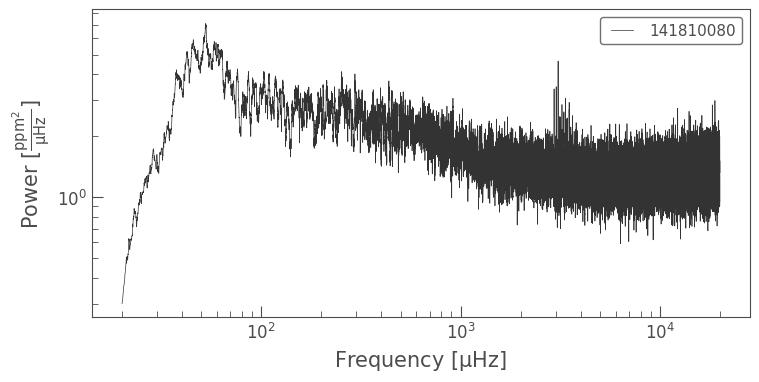

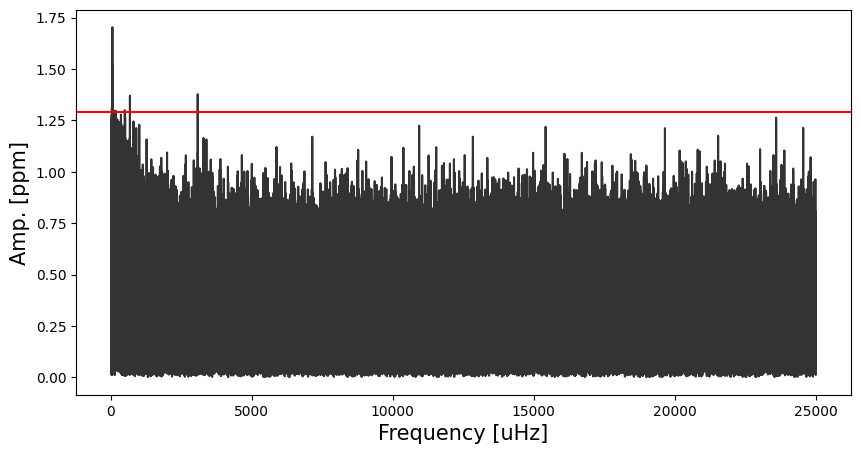

max 53.24074074074076


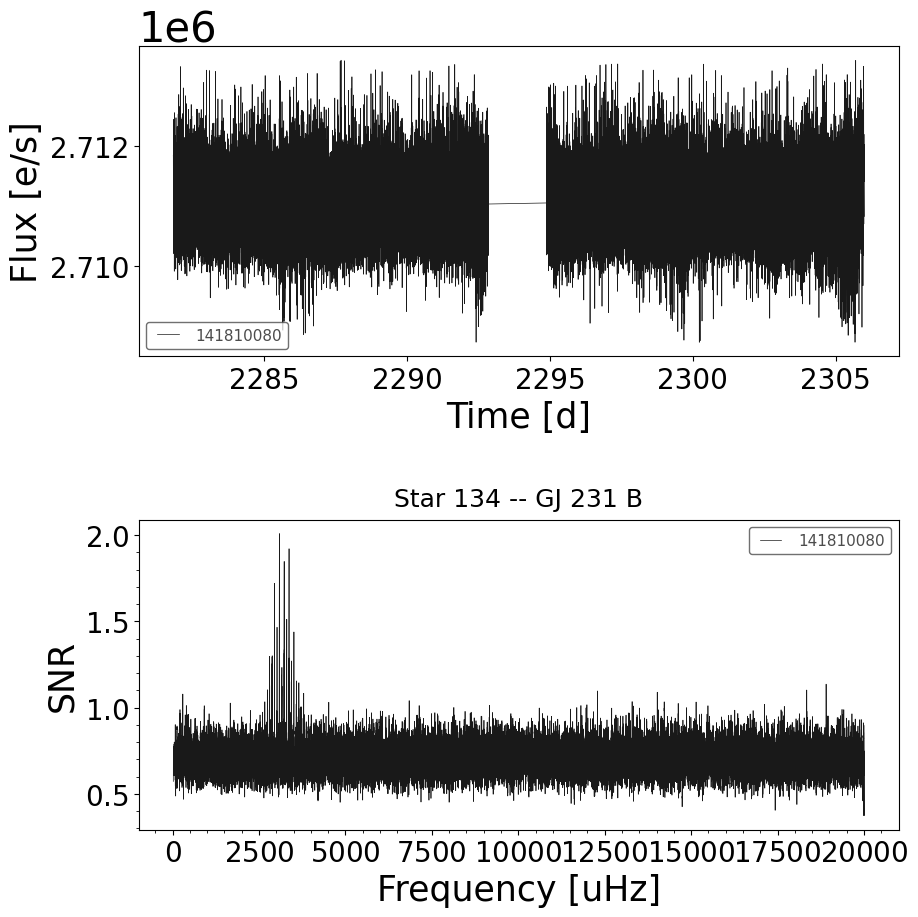

In [271]:
analyze_star(134,False,smooth_size = 2001)

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="118585685" SECTOR=29 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="118585685" SECTOR=69 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


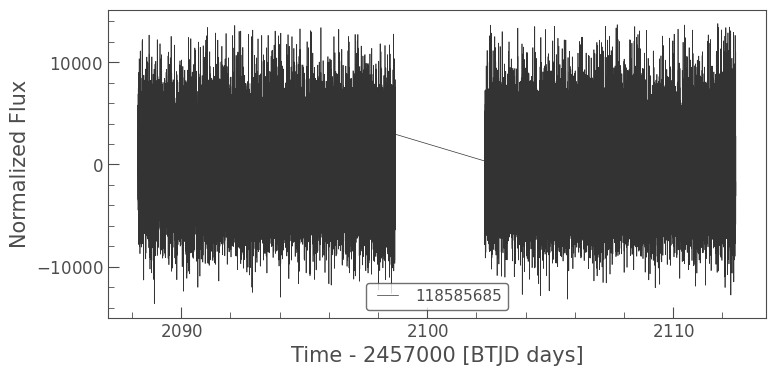

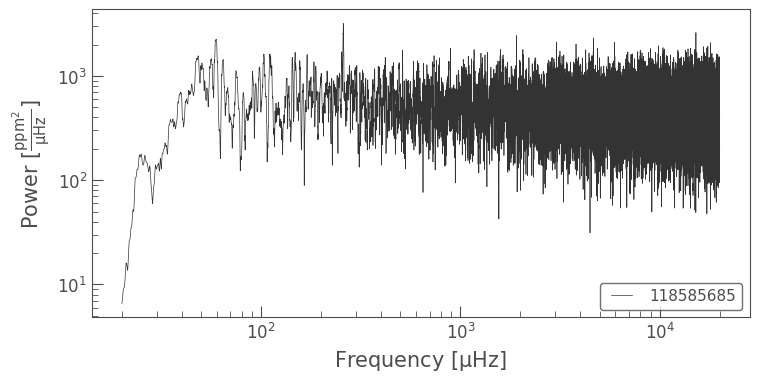

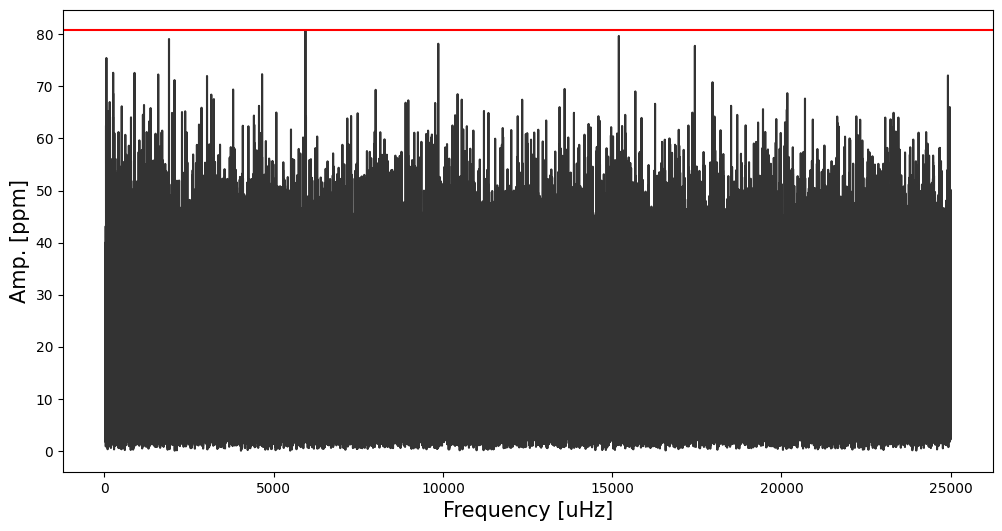

max 256.75925925925947


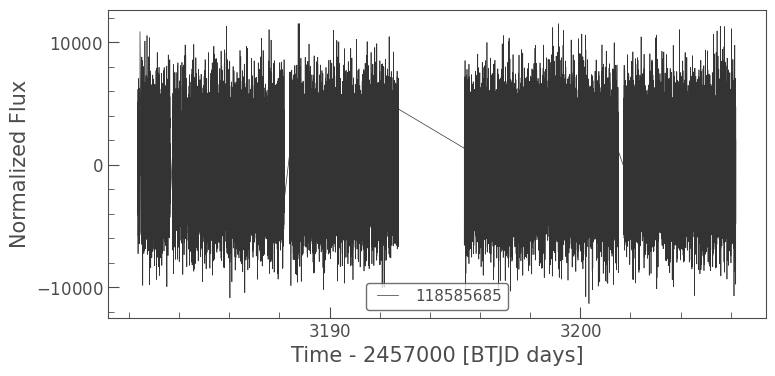

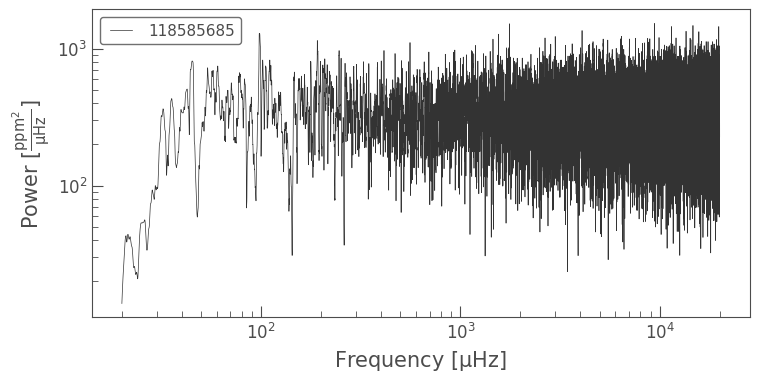

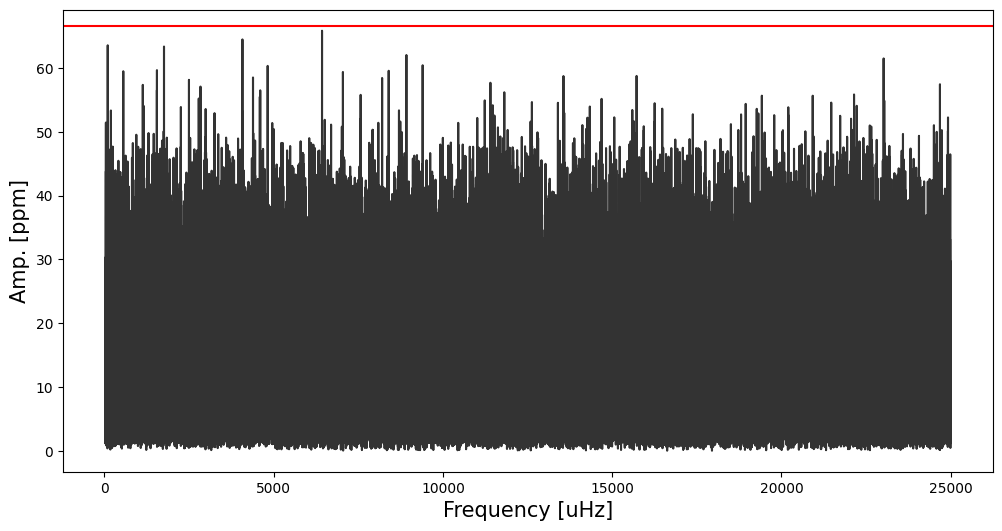

max 7574.074074074081


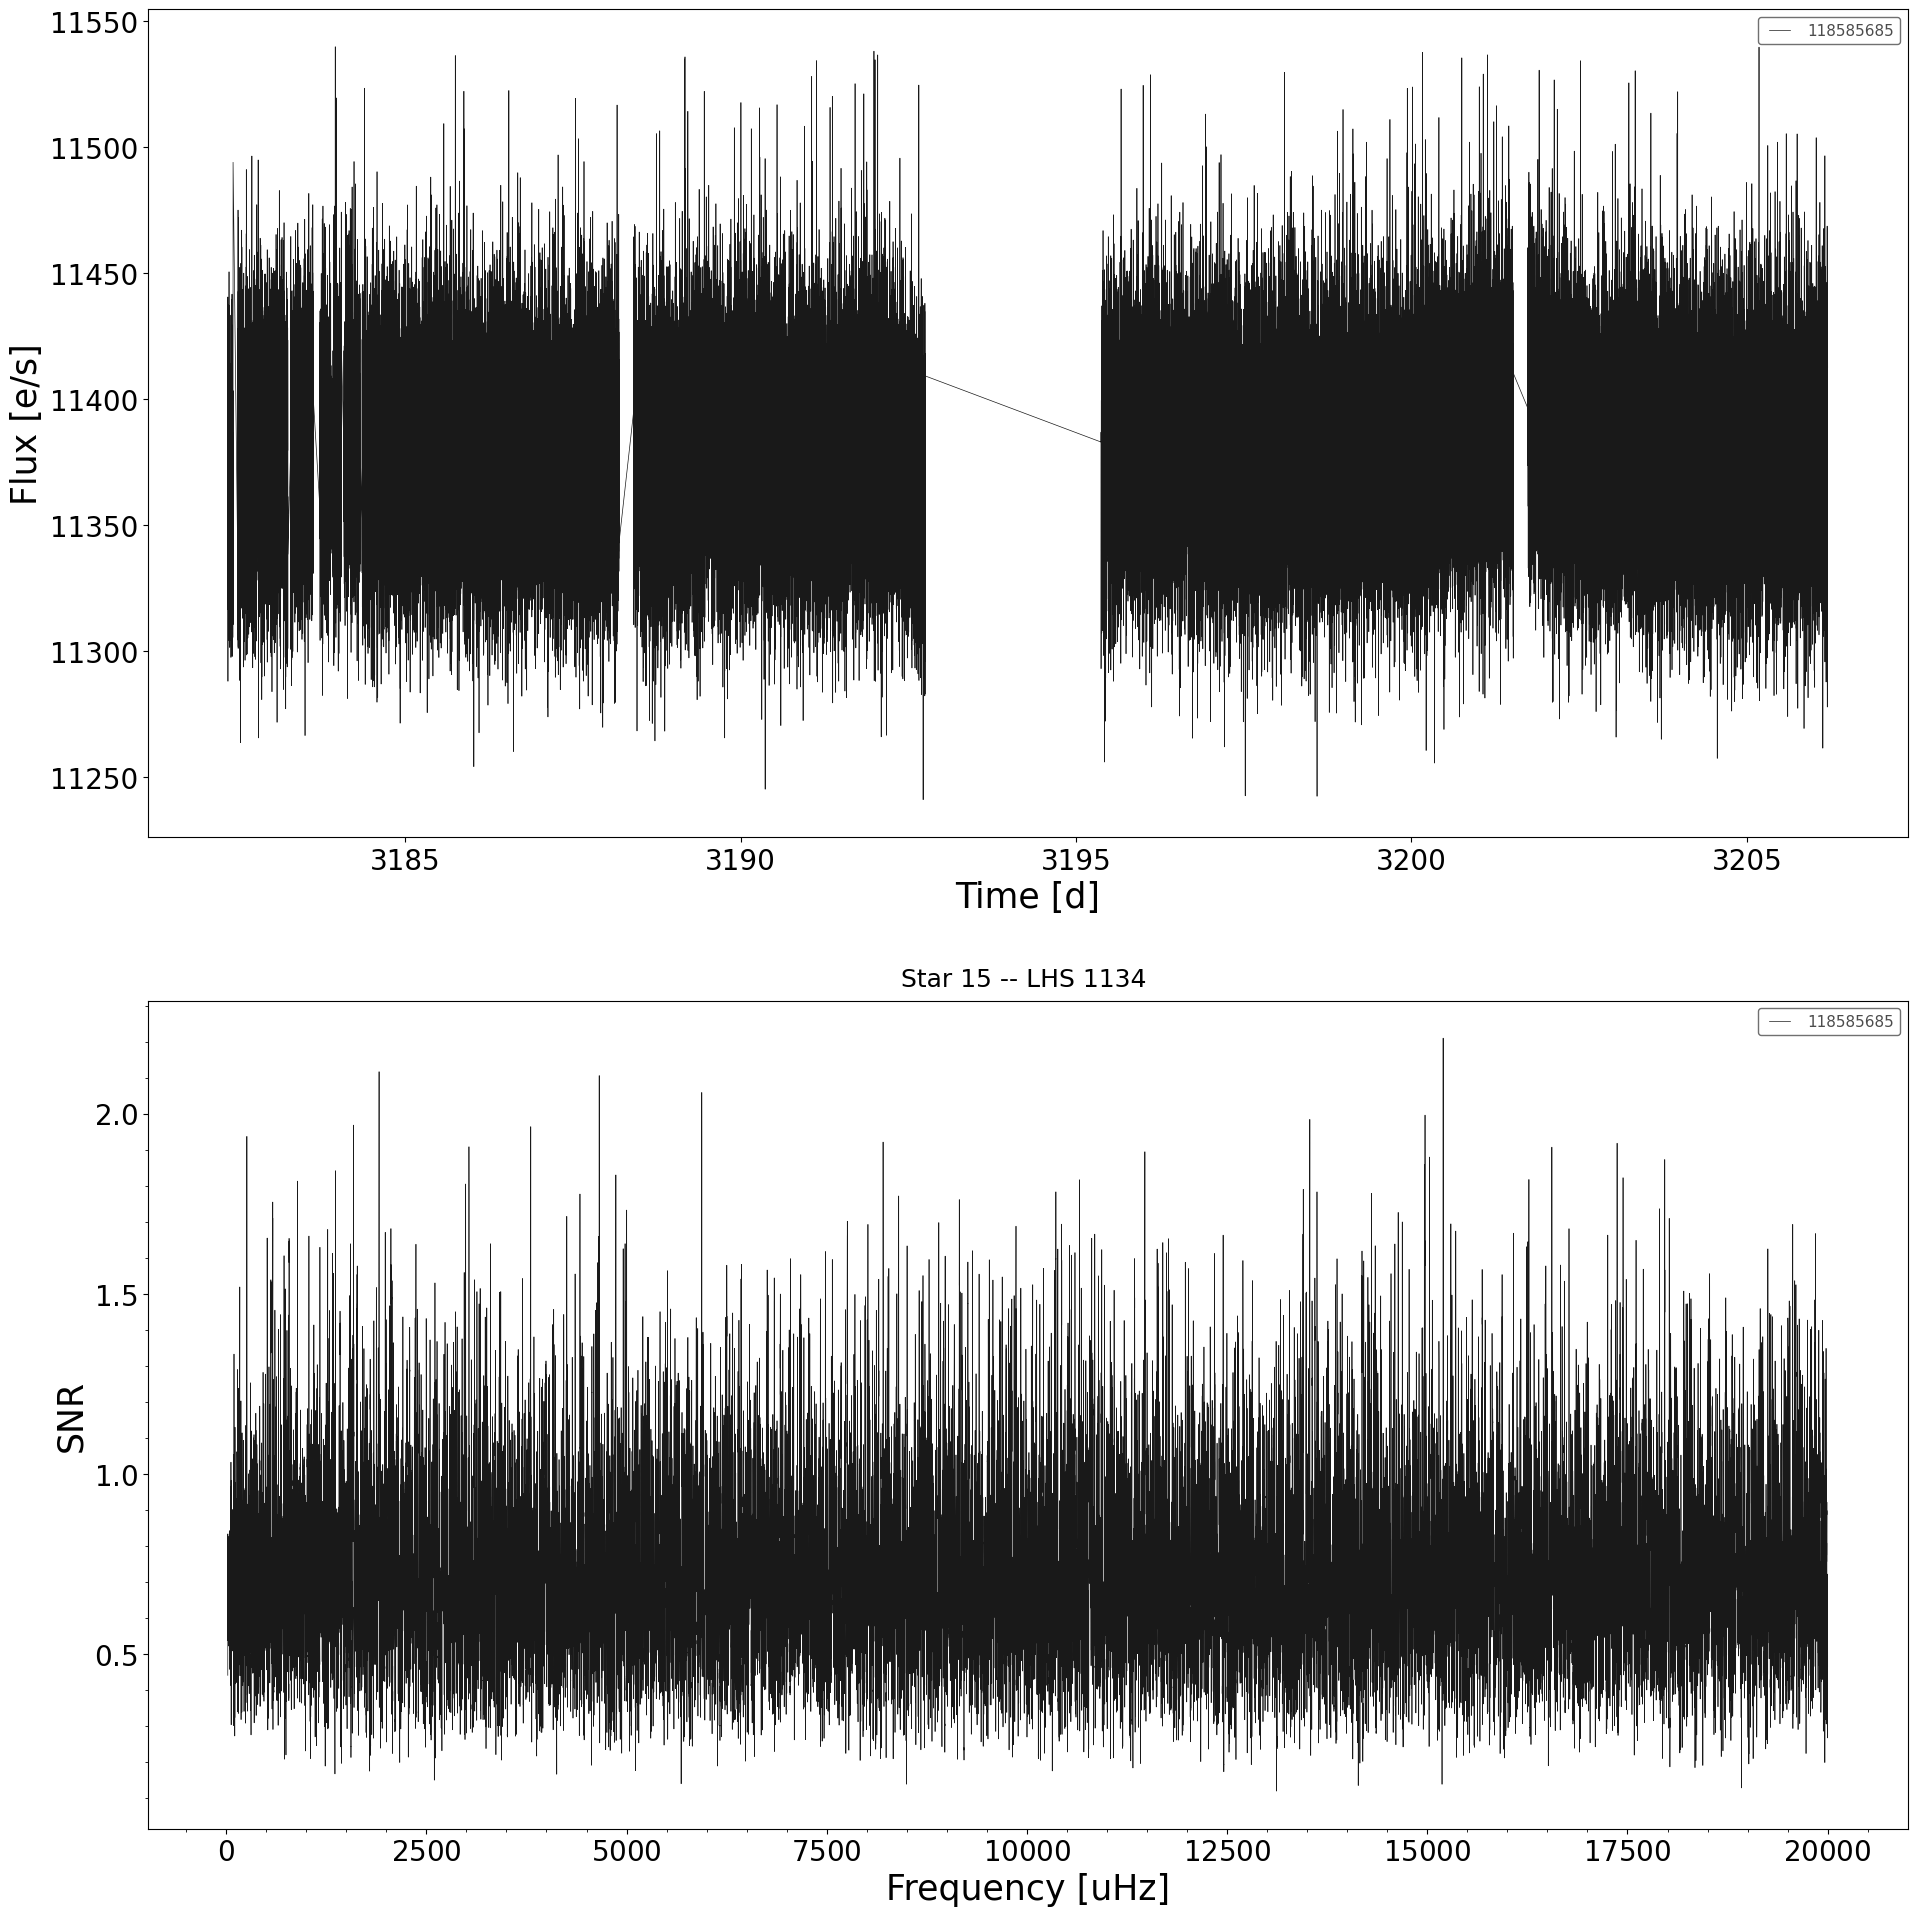

In [121]:
# real data
analyze_star(15)

LightCurveCollection of 20 objects:
    0: <TessLightCurve LABEL="141810080" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="141810080" SECTOR=66 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="141810080" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="141810080" SECTOR=67 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="141810080" SECTOR=30 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="141810080" SECTOR=65 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="141810080" SECTOR=37 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="141810080" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="141810080" SECTOR=29 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="141810080" SECTOR=64 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="141810080" SECTOR=61 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_f

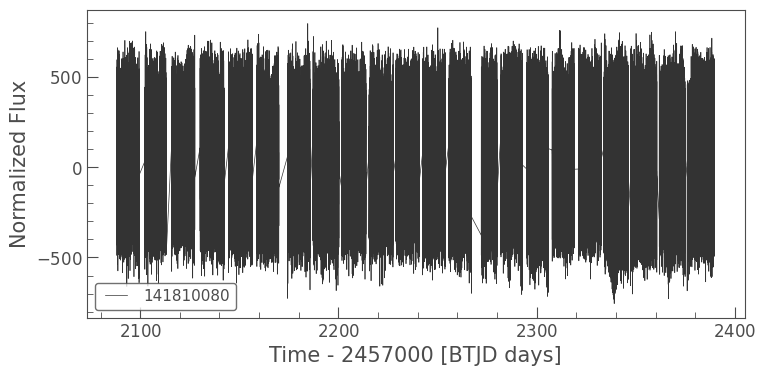

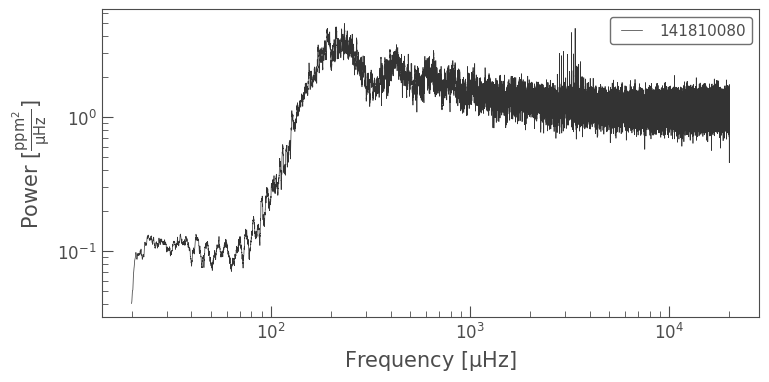

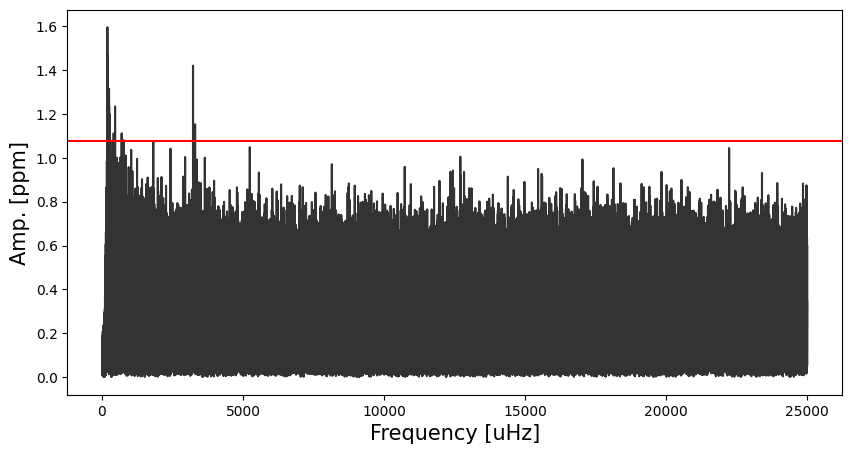

max 236.57407407407425


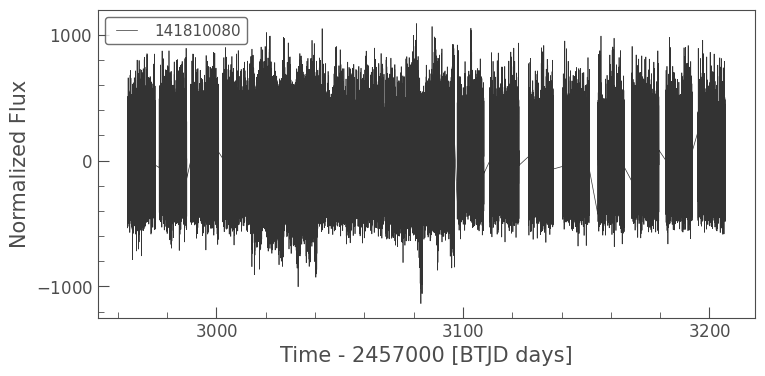

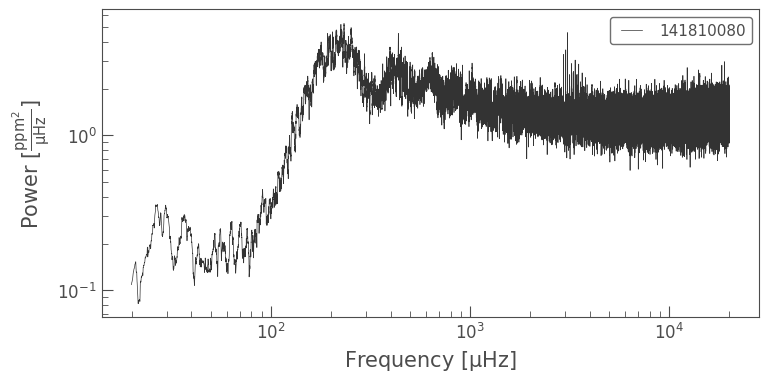

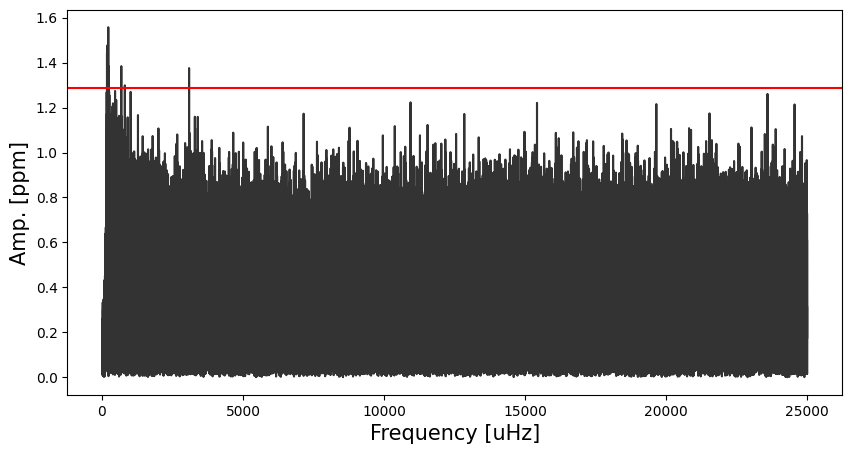

max 223.5185185185187


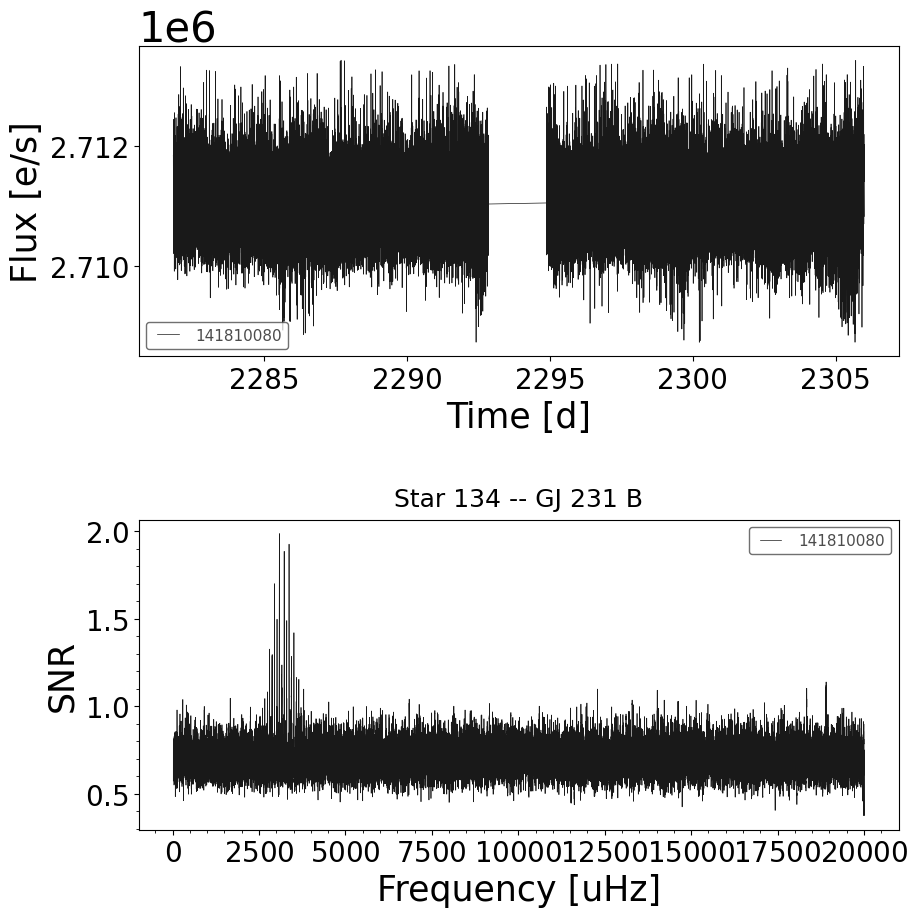

In [247]:
analyze_star(134,False,501)

In [ ]:
# fake data


In [ ]:
## load analyzed data


with open(f'/Users/caleb/research/Astro_98/lightkurve_data/thresholds.pkl','rb') as f:
    thresholds = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/power_psds.pkl','rb') as f:
    power_psds = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/flats.pkl','rb') as f:
    flats = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/powers.pkl','rb') as f:
    powers = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/dilutions.pkl','rb') as f:
    dilutions = pickle.load(f)

with open(f'/Users/caleb/research/Astro_98/lightkurve_data/stars_analyzed.pkl','rb') as f:
    stars_analyzed = pickle.load(f)


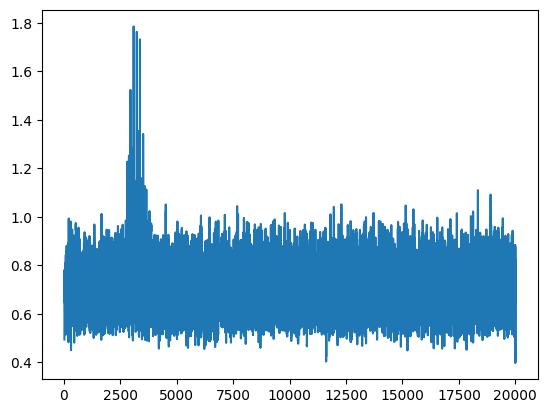

In [28]:
plt.plot(np.arange(20, 20000,0.008),flats[0])

In [204]:
lc_collection = split_obs(lcs)

In [432]:
all_paths[134].sort()

In [181]:
lcs = []
lcs_list = []
for i in all_paths[15]:
    lc = lightkurve.io.read(f'{i}')
    lcs_list.append(lc)
lcs = lightkurve.LightCurveCollection(lcs_list)


In [147]:
lcs

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="118585685" SECTOR=29 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="118585685" SECTOR=69 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [182]:
lc = lcs[0]

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

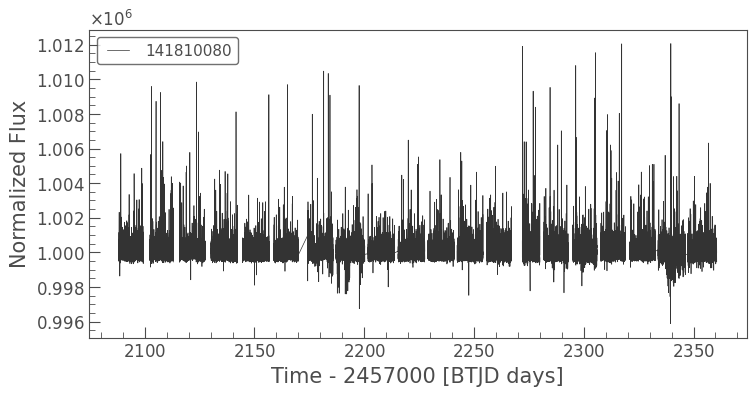

In [568]:
lc = lcs[0:10].stitch().normalize(unit='ppm')
lc.plot()

In [619]:
lc = lc.normalize(unit='ppm')

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

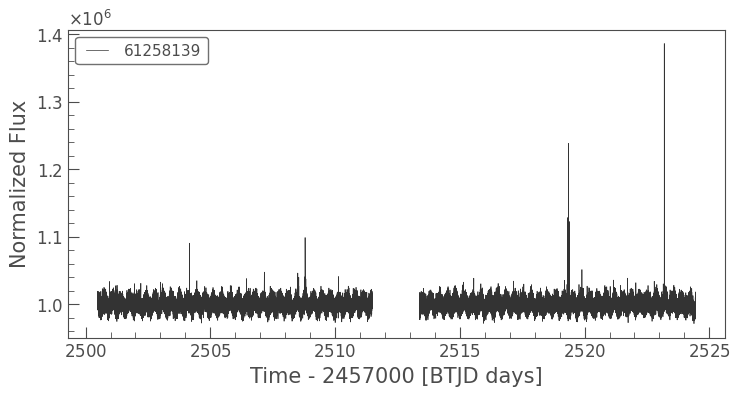

In [620]:
lc.plot()

In [621]:
lc

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,ppm,ppm,,,,,,
Time,float32,float32,int32,float64,float64,float64,float64,int32
2500.19136544286,———,———,5498208,311.22476030271116,311.22476030271116,770.0214149392843,770.0214149392843,0
2500.1915969430984,———,———,5498209,311.23864510174934,311.23864510174934,769.9793954914021,769.9793954914021,0
2500.191828443337,———,———,5498210,311.2239995972839,311.2239995972839,769.983194274581,769.983194274581,0
2500.1920599435757,———,———,5498211,311.2302289414247,311.2302289414247,769.942690690833,769.942690690833,0
2500.1922914438146,———,———,5498212,311.2097134309558,311.2097134309558,770.0218469109998,770.0218469109998,0
2500.192522944053,———,———,5498213,311.2331714886233,311.2331714886233,769.9932891809207,769.9932891809207,0
2500.1927544442915,———,———,5498214,311.22326603320454,311.22326603320454,769.9848687269239,769.9848687269239,0
2500.1929859442976,———,———,5498215,311.21260760571545,311.21260760571545,769.9846684433286,769.9846684433286,0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

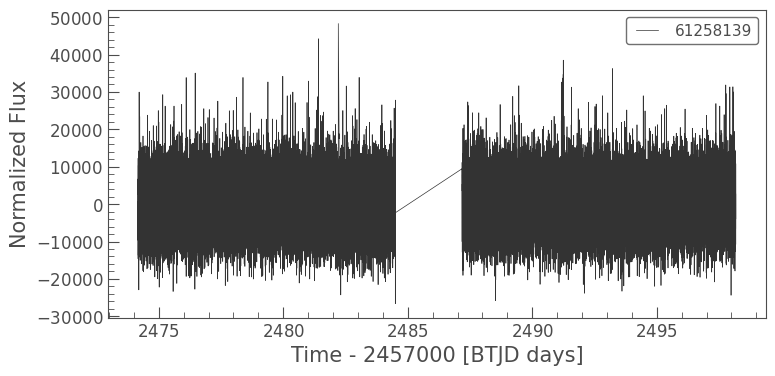

In [662]:
ppm_unit = lc.flux[0].unit
clean_lc = lc.remove_nans().remove_outliers()
flat_lc, trend_lc = clean_lc.flatten(window_length=201, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)
residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
# flat_lc['flux'] = residuals
flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6
flat_lc.plot()

In [624]:
flat_lc

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,ppm,,,,,,,
Time,float64,float64,int32,float64,float64,float64,float64,int32
2500.4869911768865,-8824.166235168685,0.006814036875671036,5499485,311.22216578564445,311.22216578564445,770.0112041435475,770.0112041435475,0
2500.487222676892,5466.253136513499,0.006833809946146571,5499486,311.2261901340712,311.2261901340712,769.9927449282061,769.9927449282061,0
2500.487454177131,1854.4092222814168,0.006831413438713554,5499487,311.2240114184267,311.2240114184267,769.9977371262132,769.9977371262132,0
2500.48768567737,2350.8232321398646,0.006822561877087888,5499488,311.2176731006526,311.2176731006526,769.9871287184346,769.9871287184346,0
2500.4879171773755,5735.707710108783,0.006830983492133794,5499489,311.2161042653847,311.2161042653847,770.008694723401,770.008694723401,0
2500.488148677614,9346.913985065486,0.006824591599999255,5499490,311.2132575296711,311.2132575296711,770.0014522542147,770.0014522542147,0
2500.48838017762,12910.581411517796,0.00682461448406085,5499491,311.2223281799923,311.2223281799923,769.993334699057,769.993334699057,0
2500.488611677859,-615.3524728157445,0.0068344365696000105,5499492,311.22758764020654,311.22758764020654,769.9802325659351,769.9802325659351,0


In [663]:
frequency = np.arange(1000, 4000,0.008)
perio = lc.normalize(unit='ppm').to_periodogram(method='lombscargle',frequency=np.arange(2, 4000,0.008)).smooth(filter_width=2)
perio_psd = lc.normalize(unit='ppm').to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,0.008),normalization='psd').smooth(filter_width=2)

In [669]:
perio.power[0].unit

Unit("ppm")

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

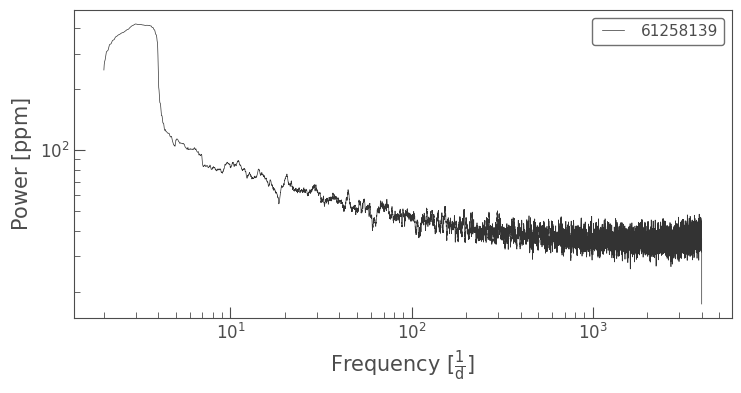

In [632]:
perio.plot(scale='log')

(100.0, 4000.0)

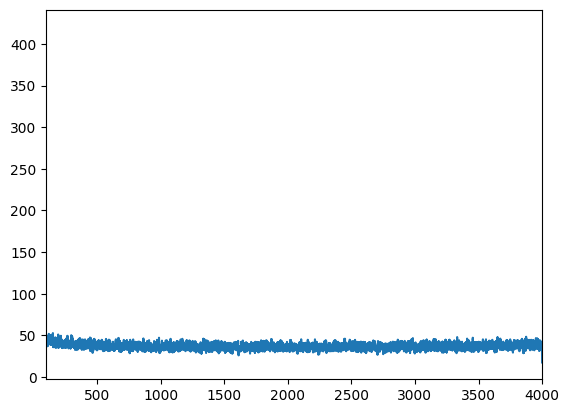

In [640]:
plt.plot(np.array(perio.frequency),np.array(perio.power))
plt.xlim(100,4000)

In [657]:
perio_psd.power

<Quantity [14178.14425853, 14235.60571295, 14284.44048994, ...,
             914.65721187,   886.64233673,   857.52227351] ppm2 / uHz>

<Axes: xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Power [$\\mathrm{\\frac{ppm^{2}}{\\mu Hz}}$]'>

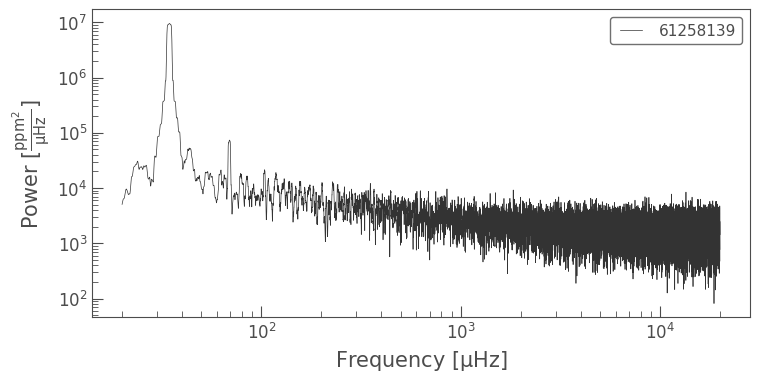

In [637]:
perio_psd.plot(scale='log')

In [251]:
# grab all paths


lcs = []
lcs_list = []
for i in all_paths[143]:
    lc = lightkurve.io.read(f'{i}')
    lcs_list.append(lc)
lcs = lightkurve.LightCurveCollection(lcs_list)

print(lcs)


LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="711366839" SECTOR=33 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="43085522" SECTOR=33 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


(33500.0, 36500.0)

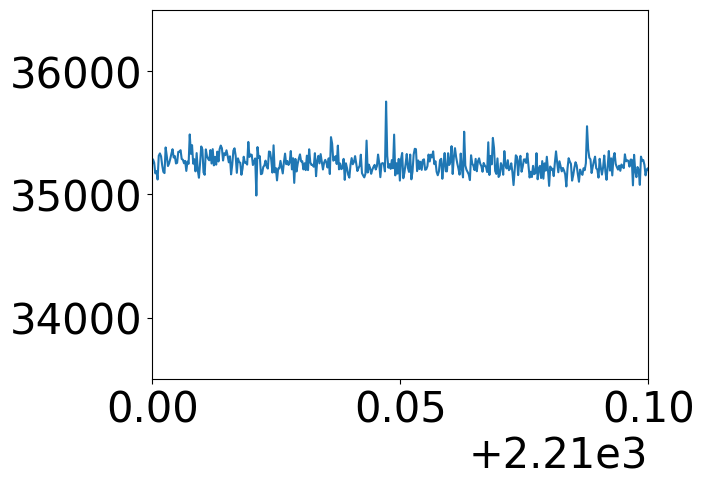

In [265]:
lc = lcs[0]
# lc.plot()
plt.plot(lc.time.value,lc.flux)
plt.xlim(2210,2210.1)
plt.ylim(33500,36500)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

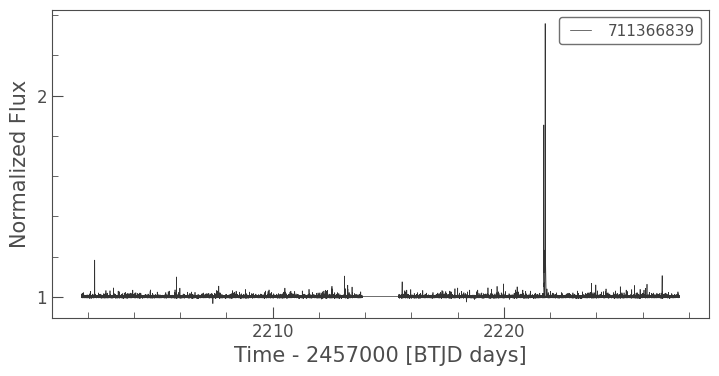

In [269]:
lc.normalize().flatten().plot()

In [716]:
lcs[0]

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,electron / s,electron / s,,,,,,
Time,float32,float32,int32,float64,float64,float64,float64,int32
2115.8866718830195,8950.953125,27.293766021728516,3838020,895.5900932068631,895.5900932068631,1038.2202631630944,1038.2202631630944,0
2115.886903368937,8928.9765625,27.277868270874023,3838021,895.5818938148074,895.5818938148074,1038.2088515488206,1038.2088515488206,0
2115.887134854971,8948.591796875,27.26959228515625,3838022,895.6070874482217,895.6070874482217,1038.2442767200725,1038.2442767200725,0
2115.8873663408904,8968.82421875,27.326648712158203,3838023,895.6025660124319,895.6025660124319,1038.2185906092168,1038.2185906092168,0
2115.8875978269252,8933.3095703125,27.270126342773438,3838024,895.5880985411428,895.5880985411428,1038.211940406283,1038.211940406283,0
2115.8878293128437,8965.0244140625,27.293777465820312,3838025,895.5932630791381,895.5932630791381,1038.233621149675,1038.233621149675,0
2115.888060798762,8944.4716796875,27.28091812133789,3838026,895.5950668278945,895.5950668278945,1038.215736122765,1038.215736122765,0
2115.888292284796,8970.6552734375,27.312416076660156,3838027,895.617181870784,895.617181870784,1038.26867824192,1038.26867824192,0


In [717]:
## Dilution
dilution = lcs[0].meta["CROWDSAP"]
print(dilution)

0.98449701


In [714]:
tic = 57984826

tess_lcfs = lk.search_lightcurve("LHS 112", mission="TESS", author="SPOC", exptime="fast").download_all(quality_bitmask="default", flux_column='pdcsap_flux')
print(tess_lcfs)
for ii, lc in enumerate(tess_lcfs):
    dilution = lc.meta["CROWDSAP"]
    print(dilution)

LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 57984826" SECTOR=57 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
0.99428904


In [683]:
lcs[0]

time,flux,flux_err,cadenceno,mom_centr1,centroid_col,centroid_row,mom_centr2,quality
,electron / s,electron / s,,,,,,
Time,float32,float32,int32,float64,float64,float64,float64,int32
2088.2395712698144,2702972.25,385.7749938964844,3718590,1385.946262405153,1385.946262405153,1877.7899591009952,1877.7899591009952,0
2088.2398027485465,2703247.25,385.78717041015625,3718591,1385.9610455985296,1385.9610455985296,1877.788145521795,1877.788145521795,0
2088.2400342273077,2703299.5,385.7801208496094,3718592,1385.9439337388678,1385.9439337388678,1877.7687132736414,1877.7687132736414,0
2088.24026570604,2703063.75,385.7615966796875,3718593,1385.9348232030657,1385.9348232030657,1877.7553802365162,1877.7553802365162,0
2088.240497184772,2703022.5,385.7496337890625,3718594,1385.9495056444996,1385.9495056444996,1877.786203277729,1877.786203277729,0
2088.2407286635034,2702981.5,385.7636413574219,3718595,1385.9510026428397,1385.9510026428397,1877.7942666762272,1877.7942666762272,0
2088.240960142236,2702937.25,385.7704772949219,3718596,1385.9619376361507,1385.9619376361507,1877.770023481571,1877.770023481571,0
2088.2411916209967,2702896.5,385.7705078125,3718597,1385.9616607887162,1385.9616607887162,1877.789755784193,1877.789755784193,0


In [680]:
tess_lcfs[0]

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2525.506494103438,———,———,-2.6025139e-03,934599,287.39940,1827.68173,2.4319241e+03,1.2991611e+01,9.6605400e+03,5.4618778e+00,———,———,1000000000000,———,———,———,———,287.39940,2.5202930e-03,1827.68173,2.5917904e-03,3.1025175e-02,-1.3109307e-01
2525.5078831069604,———,———,-2.6023986e-03,934600,287.40211,1827.68695,2.4336926e+03,1.3019629e+01,9.7126719e+03,5.4754949e+00,———,———,1000000000000,———,———,———,———,287.40211,2.5221405e-03,1827.68695,2.6016729e-03,3.4179501e-02,-1.2786831e-01
2525.509272110249,———,———,-2.6022836e-03,934601,287.40517,1827.68690,2.4080603e+03,1.3034285e+01,9.7538174e+03,5.4880056e+00,———,———,1000000000000,———,———,———,———,287.40517,2.5495971e-03,1827.68690,2.6325341e-03,3.3659030e-02,-1.2660287e-01
2525.512050117294,———,———,-2.6020531e-03,934603,287.40034,1827.67853,2.4101655e+03,1.3086796e+01,9.8543418e+03,5.5166483e+00,———,———,1000000000000,———,———,———,———,287.40034,2.5603513e-03,1827.67853,2.6310298e-03,3.0540086e-02,-1.3256012e-01
2525.5134391208167,———,———,-2.6019379e-03,934604,287.40512,1827.69075,2.4254785e+03,1.3115573e+01,9.8936094e+03,5.5263925e+00,———,———,1000000000000,———,———,———,———,287.40512,2.5469628e-03,1827.69075,2.6339716e-03,3.7465993e-02,-1.2552682e-01
2525.5162171278607,———,———,-2.6017074e-03,934606,287.40384,1827.67896,2.4295657e+03,1.3162457e+01,9.9724922e+03,5.5490851e+00,———,———,1000000000000,———,———,———,———,287.40384,2.5523913e-03,1827.67896,2.6257420e-03,3.2442775e-02,-1.2706690e-01
2525.535663179501,———,———,-2.6000915e-03,934620,287.40559,1827.67374,2.3957271e+03,1.3468527e+01,1.0573637e+04,5.7062550e+00,———,———,1000000000000,———,———,———,———,287.40559,2.6466167e-03,1827.67374,2.7198456e-03,3.5219915e-02,-1.3589875e-01
2525.537052183256,———,———,-2.5999760e-03,934621,287.40423,1827.68364,2.3923296e+03,1.3484904e+01,1.0602045e+04,5.7177815e+00,———,———,1000000000000,———,———,———,———,287.40423,2.6540265e-03,1827.68364,2.7386690e-03,4.2747647e-02,-1.2148615e-01


In [3]:
import numpy as np
ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/s4tess_llrgb.asc")

In [4]:
print(ascii_grid[0:10])

[ 19.3400637  59.2486971  92.370153   87.1863879 102.7884287 107.1498991
  83.6764028 105.9076783 143.9990598 137.8134188]


In [5]:
plt.plot(ascii_grid)
plt.show()

NameError: name 'plt' is not defined